In [32]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forecast as fc
import pickle

In [33]:
# loading data

provinces = pd.read_csv('..\data\dati-province\dpc-covid19-ita-province.csv')
today = '2021-06-26T17:00:00'
today_data = provinces.loc[provinces['data']==today]

population = pd.read_csv('..\data\Popolazione_province.csv', index_col=0)

p_list = pd.read_csv('..\data\Provinces_list.csv')['Sigla'].tolist()

# Load the coordinates from the file
with open('..\data\coordinates_dict.pickle', 'rb') as file:
    coord_df = pickle.load(file)

# Load the distances from the file
with open('..\data\distances_df.pickle', 'rb') as file:
    distances_df = pickle.load(file)

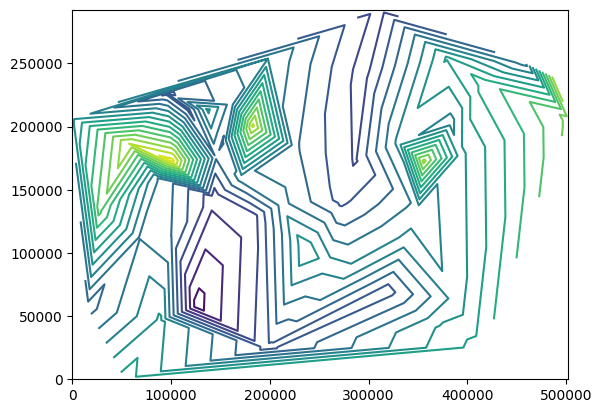

In [34]:
# Load the dictionary from the file
with open('..\data\provinces_fit.pickle', 'rb') as file:
    provinces_fitted = pickle.load(file)

selected_start=200
wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in p_list]
wave_params = [ provinces_fitted[sigla].L_waves[wave_index[i]].params  for i, sigla in enumerate(p_list)]
z1 = [param['K'].value for param in wave_params]
z2 = [param['b'].value for param in wave_params]
z3 = [param['c'].value for param in wave_params]
z4 = [param['t_max'].value for param in wave_params]

plt.figure()
plt.tricontour([coord_df[sigla][0] for sigla in p_list], [coord_df[sigla][1] for sigla in p_list], z4, levels=20, cmap='viridis')

In [35]:
test_labels = ['MO','RO', 'VI', 'AL', 'BI', 'PN', 'MB']
data_labels = [sigla for sigla in p_list if not(sigla in test_labels)]
x_data = [ coord_df[sigla][0] for sigla in (data_labels) ]
y_data = [ coord_df[sigla][1] for sigla in (data_labels) ]
x_test = [ coord_df[sigla][0] for sigla in (test_labels) ]
y_test = [ coord_df[sigla][1] for sigla in (test_labels) ]

In [36]:
selected_start=200
data_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in data_labels]
data_wave_params = [ provinces_fitted[sigla].L_waves[data_wave_index[i]].params  for i, sigla in enumerate(data_labels)]
z1_data = [param['K'].value for param in data_wave_params]
z2_data = [param['b'].value for param in data_wave_params]
z3_data = [param['c'].value for param in data_wave_params]

test_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in test_labels]
test_wave_params = [ provinces_fitted[sigla].L_waves[test_wave_index[i]].params  for i, sigla in enumerate(test_labels)]
z1_test = [param['K'].value for param in test_wave_params]
z2_test = [param['b'].value for param in test_wave_params]
z3_test = [param['c'].value for param in test_wave_params]

In [37]:
# Radial basis Function approach

def RBF(z_data, coor_data, coor_test, sigma):
    n_data = len(coor_data[0])
    n_test = len(coor_test[0])

    def radial_basis(x,y,sigma):
        return 1./(1+(x**2 + y**2)/sigma**2)

    # Initial shape model
    z_m = [sum(z_data[0])/len(z_data[0]), sum(z_data[1])/len(z_data[1]), sum(z_data[2])/len(z_data[2]) ]

    S = np.zeros((n_data, n_data, 3))
    Delta = np.zeros((n_data, 3))
    W = np.zeros((n_data, 3))
    for k in range(3):
        for i in range(n_data):
            for j in range(n_data):
                S[i,j,k] = radial_basis( coor_data[0][i]-coor_data[0][j], coor_data[1][i]-coor_data[1][j], sigma[k] )

    # Compute delta
    for k in range(3):
        for i in range(n_data):
            Delta[i][k] = z1_data[i]-z_m[k]

    # Compute Weights
    for k in range(3):
        W[:,k] = np.linalg.solve(S[:,:,k],Delta[:,k])

    # Extimation in the test set
    Z_RBF = np.zeros((n_test, 3))
    for k in range(3):
        Z_RBF[:,k] = z_m[k]*np.ones(n_test)
    for k in range(3):
        for i in range(n_test):
            for j in range(n_data):
                Z_RBF[i, k] = Z_RBF[i, k] +  W[j,k]*radial_basis( coor_test[0][i] - coor_data[0][j], coor_test[1][i] - coor_data[1][j], sigma[k] )
    return Z_RBF

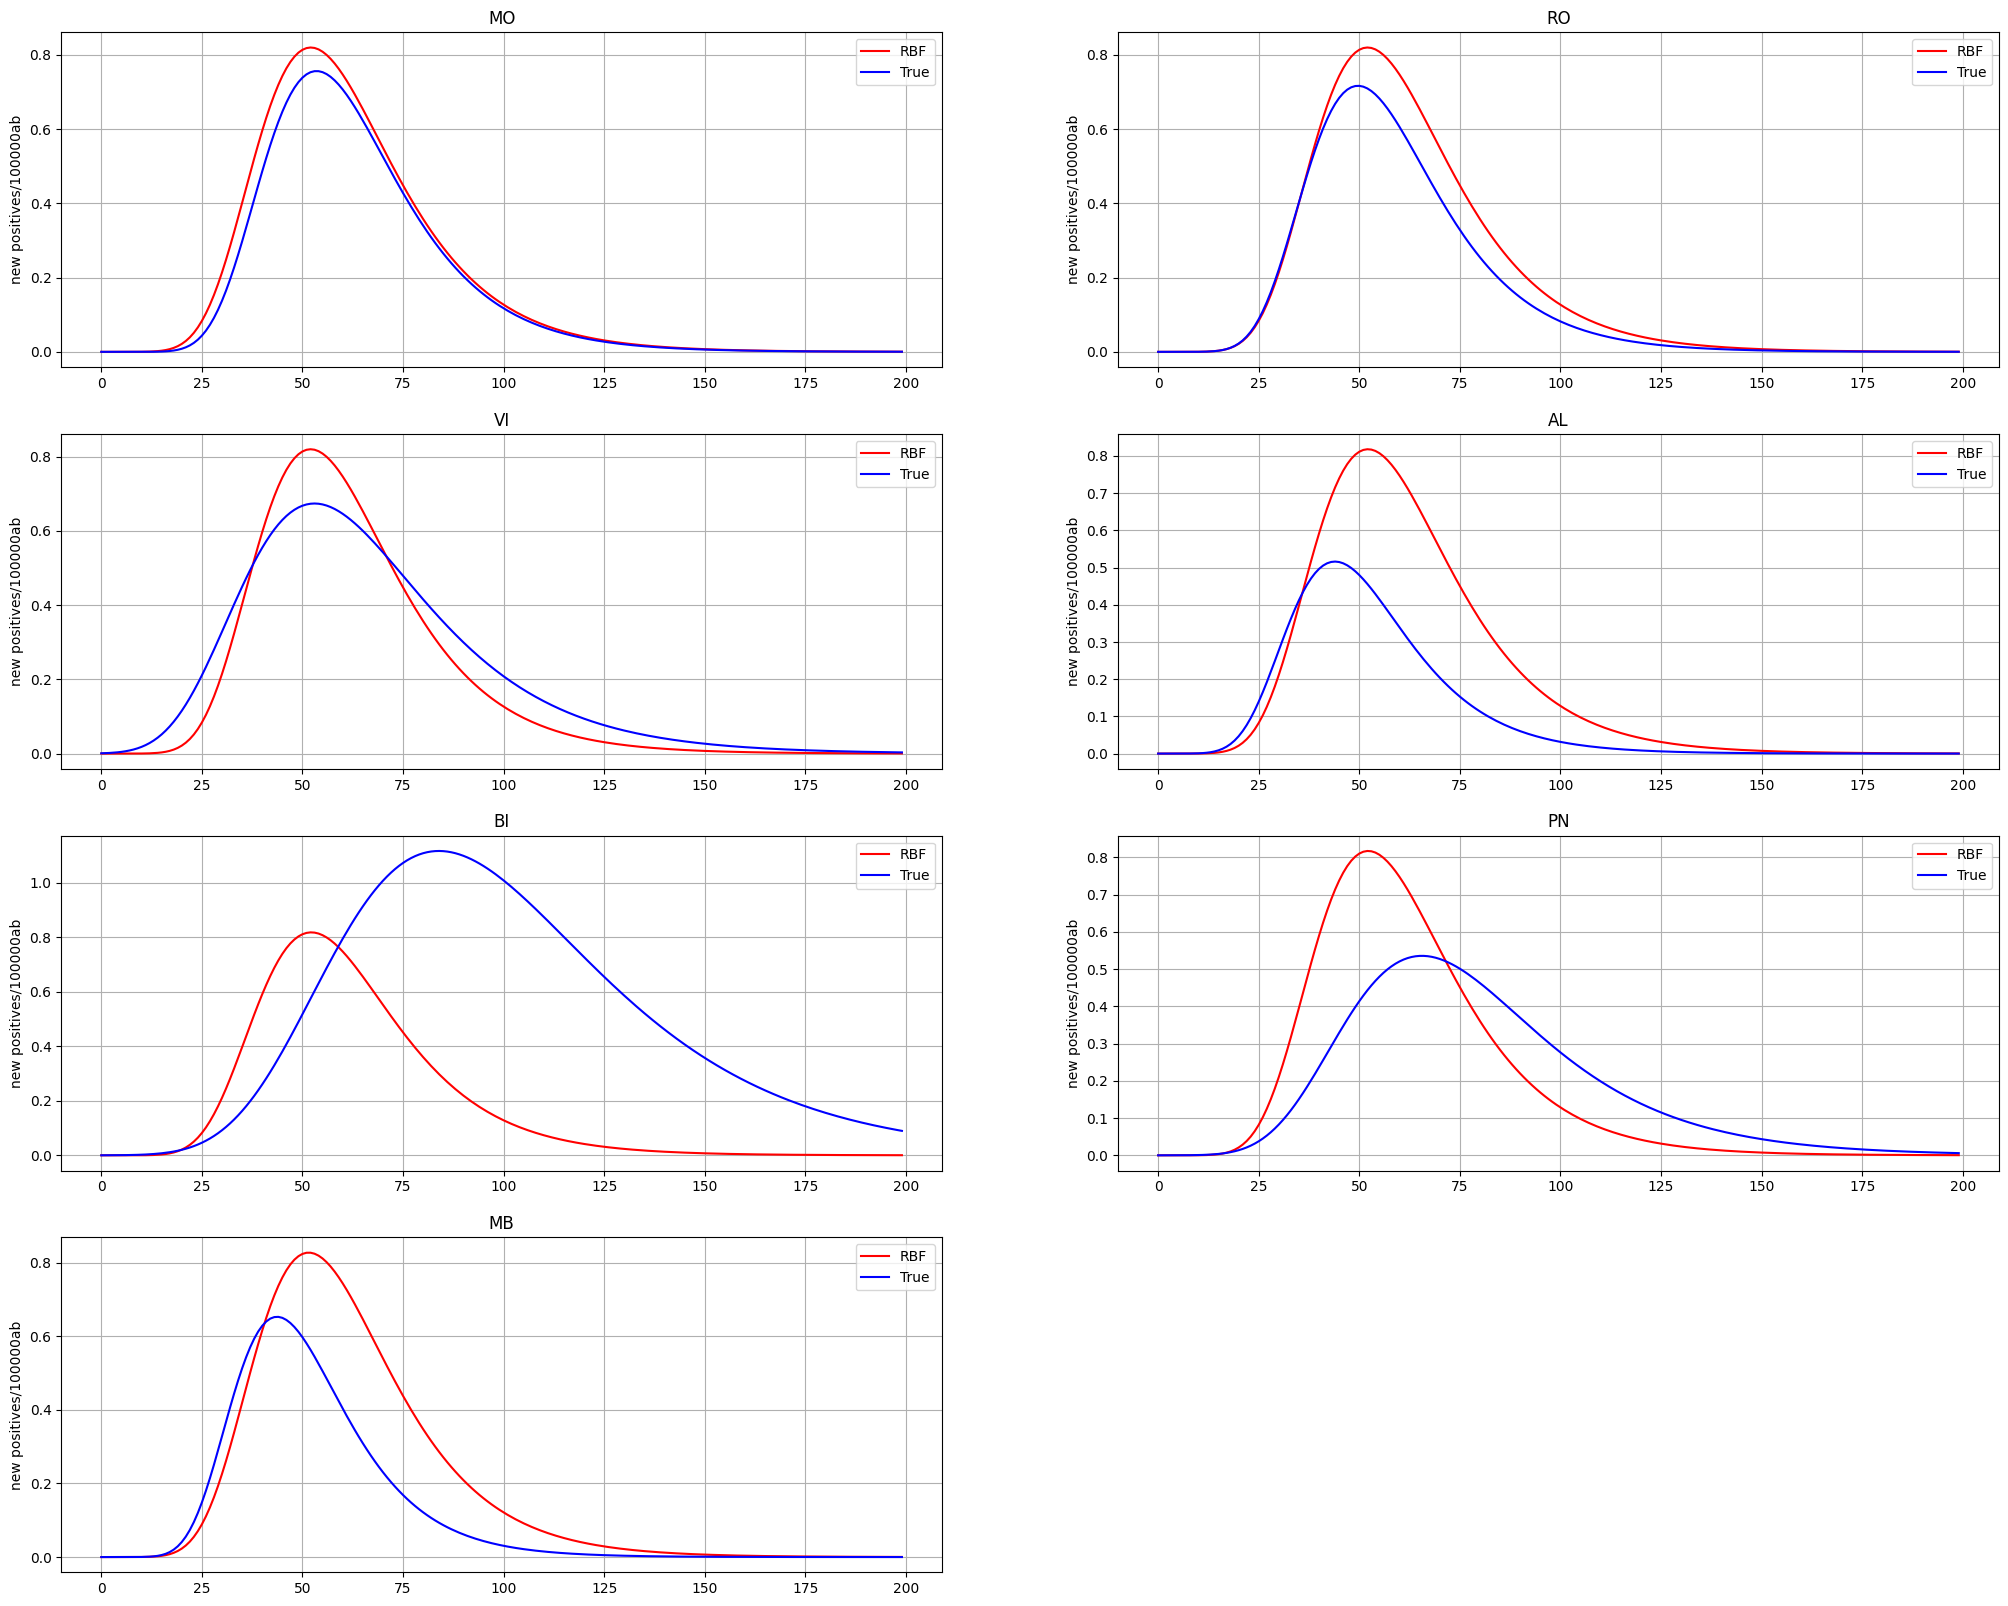

In [38]:
sigma = [50, 50, 50]
Z_RBF = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma)
Z_target = np.array([z1_test, z2_test, z3_test]).T
# Plotting curves
tt = np.arange(0,200)
plt.figure(figsize=(25,20))
j=0
for i,sigla in enumerate(test_labels):
    index = p_list.index(sigla)
    plt.subplot(4,2,j+1)
    plt.title(sigla)
    plt.grid(True)
    wave_RBF = fc.gompertz(tt,Z_RBF[i][0], Z_RBF[i][1], Z_RBF[i][2])
    wave_true = fc.gompertz(tt,z1[index], z2[index], z3[index])
    plt.plot(tt,wave_RBF, color='red', label='RBF')
    plt.plot(tt,wave_true, color='blue', label='True')
    plt.ylabel('new positives/100000ab')
    plt.legend()
    j+=1

In [39]:
"""
def CostFunctional(sigma, ystar, z_data, coor_data, coor_test):
    def inputOutput(sigma):
        yh = RBF(z_data, coor_data, coor_test, sigma)
        return yh
    
    # print('Evaluating Cost Functional at: ['+str(sigma[0])+','+str(sigma[1])+','+str(sigma[2])+']')
    yh = inputOutput(sigma)
    return ((ystar-yh)**2).mean(axis=None)
    """

"\ndef CostFunctional(sigma, ystar, z_data, coor_data, coor_test):\n    def inputOutput(sigma):\n        yh = RBF(z_data, coor_data, coor_test, sigma)\n        return yh\n    \n    # print('Evaluating Cost Functional at: ['+str(sigma[0])+','+str(sigma[1])+','+str(sigma[2])+']')\n    yh = inputOutput(sigma)\n    return ((ystar-yh)**2).mean(axis=None)\n    "

In [40]:
"""
# Define a grid for Sigma
s1 = np.linspace(1e-15,1e12, 15)
s2 = np.linspace(1e-15,1e12, 15)
s3 = np.linspace(1e-15,1e12, 15)
J = 1e12
J_list=[]

for i, x in enumerate(s1):
    print('advancing: '+str(i/s1.shape[0]*100)+'%')
    for y in s2:
        for z in s3:
            c = CostFunctional([x,y,z],Z_target,[z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test])
            if c < J:
                J = c
                J_list.append(J)
                sigma_opt = [x,y,z]

print(sigma_opt)
plt.figure()
plt.plot(J_list, marker='.')
plt.grid(True)
"""

"\n# Define a grid for Sigma\ns1 = np.linspace(1e-15,1e12, 15)\ns2 = np.linspace(1e-15,1e12, 15)\ns3 = np.linspace(1e-15,1e12, 15)\nJ = 1e12\nJ_list=[]\n\nfor i, x in enumerate(s1):\n    print('advancing: '+str(i/s1.shape[0]*100)+'%')\n    for y in s2:\n        for z in s3:\n            c = CostFunctional([x,y,z],Z_target,[z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test])\n            if c < J:\n                J = c\n                J_list.append(J)\n                sigma_opt = [x,y,z]\n\nprint(sigma_opt)\nplt.figure()\nplt.plot(J_list, marker='.')\nplt.grid(True)\n"

In [41]:
"""
sigma=[50,50,50]
Z_RBF = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma)
Z_RBF_ = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma_opt)
plt.figure(figsize=(25,25))
for i,sigla in enumerate(test_labels):
    index = p_list.index(sigla)
    plt.subplot(8,2, i+1)
    plt.title(sigla)
    plt.grid(True)
    wave_RBF = fc.gompertz(tt,Z_RBF[i][0], Z_RBF[i][1], Z_RBF[i][2])
    wave_RBF_ = fc.gompertz(tt,Z_RBF_[i][0], Z_RBF_[i][1], Z_RBF_[i][2])
    wave_true = fc.gompertz(tt,z1[index], z2[index], z3[index])
    plt.plot(tt,wave_RBF, color='red', label='RBF')
    plt.plot(tt,wave_RBF_, color='orange', label='RBF_opt')
    plt.plot(tt,wave_true, color='blue', label='True')
    plt.legend()
    j+=1
    """

"\nsigma=[50,50,50]\nZ_RBF = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma)\nZ_RBF_ = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma_opt)\nplt.figure(figsize=(25,25))\nfor i,sigla in enumerate(test_labels):\n    index = p_list.index(sigla)\n    plt.subplot(8,2, i+1)\n    plt.title(sigla)\n    plt.grid(True)\n    wave_RBF = fc.gompertz(tt,Z_RBF[i][0], Z_RBF[i][1], Z_RBF[i][2])\n    wave_RBF_ = fc.gompertz(tt,Z_RBF_[i][0], Z_RBF_[i][1], Z_RBF_[i][2])\n    wave_true = fc.gompertz(tt,z1[index], z2[index], z3[index])\n    plt.plot(tt,wave_RBF, color='red', label='RBF')\n    plt.plot(tt,wave_RBF_, color='orange', label='RBF_opt')\n    plt.plot(tt,wave_true, color='blue', label='True')\n    plt.legend()\n    j+=1\n    "